# Task
Our task is simple, recognize handwritten digits. We will use MNIST dataset for this tutorial.


# Import necessary library
In this tutorial, we are going to use pytorch, the cutting-edge deep learning framework to complete our task.

In [8]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
from torchsummary import summary

In [9]:
## Create dataloader, in PyTorch, we feed the trainer data with use of dataloader
## We create dataloader with dataset from torchvision, 
## and we dont have to download it seperately, all automatically done

# Define batch size, batch size is how much data you feed for training in one iteration
batch_size_train = 64 # We use a small batch size here for training
batch_size_test = 1024 #

# Learning rate and momentum
learning_rate = 0.01  # Disesuaikan learning rate
momentum = 0.9

# define how image transformed
image_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.1307,), (0.3081,))
])
#image datasets
train_dataset = torchvision.datasets.MNIST('dataset/',
                                           train=True,
                                           download=True,
                                           transform=image_transform)
test_dataset = torchvision.datasets.MNIST('dataset/',
                                          train=False,
                                          download=True,
                                          transform=image_transform)
#data loaders
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=batch_size_train,
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=batch_size_test,
                                          shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

9913344it [00:06, 1641233.35it/s]                             


Extracting dataset/MNIST\raw\train-images-idx3-ubyte.gz to dataset/MNIST\raw


  0%|          | 0/28881 [00:00<?, ?it/s]

29696it [00:00, 27278592.11it/s]         
  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting dataset/MNIST\raw\train-labels-idx1-ubyte.gz to dataset/MNIST\raw



1649664it [00:00, 1840827.59it/s]                             


Extracting dataset/MNIST\raw\t10k-images-idx3-ubyte.gz to dataset/MNIST\raw



5120it [00:00, ?it/s]                   

Extracting dataset/MNIST\raw\t10k-labels-idx1-ubyte.gz to dataset/MNIST\raw




c:\Users\ACER\anaconda3\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Label: tensor(9)


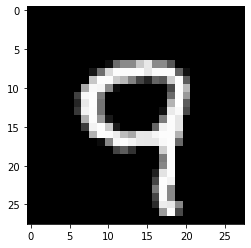

In [10]:
# import library
import matplotlib.pyplot as plt
# We can check the dataloader
_, (example_datas, labels) = next(enumerate(test_loader))
sample = example_datas[0][0]
# show the data
plt.imshow(sample, cmap='gray', interpolation='none')
print("Label: "+ str(labels[0]))

In [12]:
## Now we can start to build our CNN model
## Then define the model class
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5, stride=1)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5, stride=1)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.max_pool2d(x, 2)
        x = F.relu(x)
        x = self.conv2(x)
        x = self.conv2_drop(x)
        x = F.max_pool2d(x, 2)
        x = F.relu(x)
        x = x.view(-1, 320)
        x = self.fc1(x)
        x = F.relu(x)
        x = F.dropout(x)
        x = self.fc2(x)
        return F.log_softmax(x)

In [13]:
## create model and optimizer
device = "cpu"
model = CNN().to(device)
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

In [14]:
from tqdm import tqdm_notebook as tqdm
##define train function
def train(model, device, train_loader, optimizer, epoch, log_interval=10000):
    model.train()
    tk0 = tqdm(train_loader, total=int(len(train_loader)))
    counter = 0
    for batch_idx, (data, target) in enumerate(tk0):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        counter += 1
        tk0.set_postfix(loss=(loss.item()*data.size(0) / (counter * train_loader.batch_size)))
##define test function
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [15]:
num_epoch = 10

for epoch in range(1, num_epoch + 1):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

<ipython-input-14-c9ff4c47fefb>:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  tk0 = tqdm(train_loader, total=int(len(train_loader)))


c:\Users\ACER\anaconda3\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
<ipython-input-12-361744ca031c>:25: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)




Test set: Average loss: 0.1881, Accuracy: 9427/10000 (94.27%)





Test set: Average loss: 0.1364, Accuracy: 9610/10000 (96.10%)





Test set: Average loss: 0.1192, Accuracy: 9637/10000 (96.37%)





Test set: Average loss: 0.1025, Accuracy: 9703/10000 (97.03%)





Test set: Average loss: 0.0988, Accuracy: 9702/10000 (97.02%)





Test set: Average loss: 0.0968, Accuracy: 9697/10000 (96.97%)





Test set: Average loss: 0.0838, Accuracy: 9765/10000 (97.65%)





Test set: Average loss: 0.0867, Accuracy: 9747/10000 (97.47%)





Test set: Average loss: 0.0823, Accuracy: 9755/10000 (97.55%)





Test set: Average loss: 0.0860, Accuracy: 9756/10000 (97.56%)



In [16]:
from torchsummary import summary
summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 24, 24]             260
            Conv2d-2             [-1, 20, 8, 8]           5,020
         Dropout2d-3             [-1, 20, 8, 8]               0
            Linear-4                   [-1, 50]          16,050
            Linear-5                   [-1, 10]             510
Total params: 21,840
Trainable params: 21,840
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.06
Params size (MB): 0.08
Estimated Total Size (MB): 0.15
----------------------------------------------------------------


<ipython-input-12-361744ca031c>:25: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)
